# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Lab 8 - Bayesian Analysis, Part 1 - JAGS (+RL setup)



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Mark Glickman and Pavlos Protopapas 


<hr style="height:2pt">

Note that this lab has been tested with 
* pandas version 0.22.0
* rpy2 version 2.9.4

The latest libraries may have changed somewhat since these versions; if you are having problems, try using these versions.

In this lab, we are working with JAGS, so make sure that it is installed on your system.

In [2]:
import os
os.environ['R_HOME'] = "/Users/anthonyrentsch/anaconda3/envs/109b/lib/R"
#"/usr/share/anaconda3/lib/R"

In [3]:
import pyjags
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 

import pandas as pd
import rpy2

from rpy2.robjects.packages import importr
#If there are errors about missing R packages, run the code below:
# r_utils = importr("utils")
# r_utils.install_packages('coda')
r_coda = importr("coda")

from rpy2.robjects import pandas2ri
pandas2ri.activate()

## Example 1: A Bayesian Coin Flip

**The idea here is to use JAGS to estimate how fair a coin is, based on 100 coin flips.**

In [4]:
coinflip_code = '''
model {
  for (i in 1:N){
    x[i] ~ dbern(theta)
  }
  theta ~ dunif(0,1)
}
'''

In [5]:
#generate some data for our coin
coinflip_N = 100
true_theta = 0.6
coinflip_x = np.random.binomial(1, true_theta, coinflip_N)

In [6]:
init_theta = 0.5 #prior is that coin is fair
n_chains = 3

coinflip_model = pyjags.Model(coinflip_code, data=dict(x=coinflip_x, N=coinflip_N), init = dict(theta=init_theta), chains=n_chains)


In [7]:
coinflip_burnin = coinflip_model.sample(500, vars=['theta']) #warmup/burn-in
coinflip_samples = coinflip_model.sample(2500, vars=['theta'])


sampling: iterations 1500 of 1500, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 7500 of 7500, elapsed 0:00:00, remaining 0:00:00


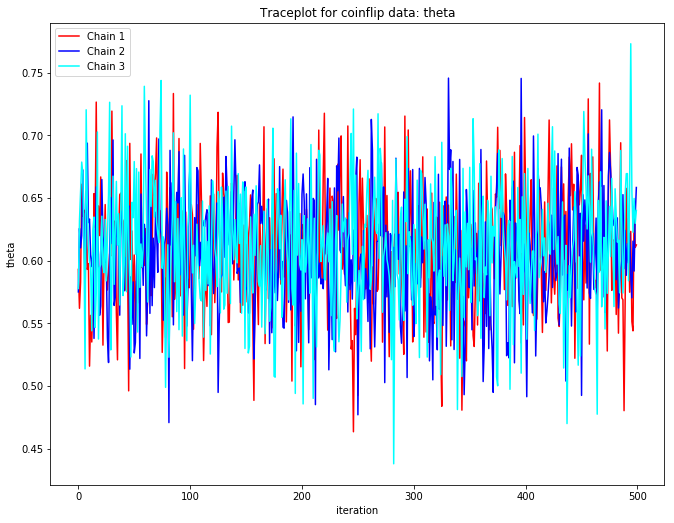

In [8]:
_ = plt.figure(figsize=(11,8.5))
_ = plt.plot(range(500),coinflip_burnin['theta'][0,:,0],color="red",label="Chain 1")
_ = plt.plot(range(500),coinflip_burnin['theta'][0,:,1],color="blue",label="Chain 2")
_ = plt.plot(range(500),coinflip_burnin['theta'][0,:,2],color="cyan",label="Chain 3")
_ = plt.xlabel("iteration")
_ = plt.ylabel("theta")
_ = plt.title("Traceplot for coinflip data: theta")
_ = plt.legend()

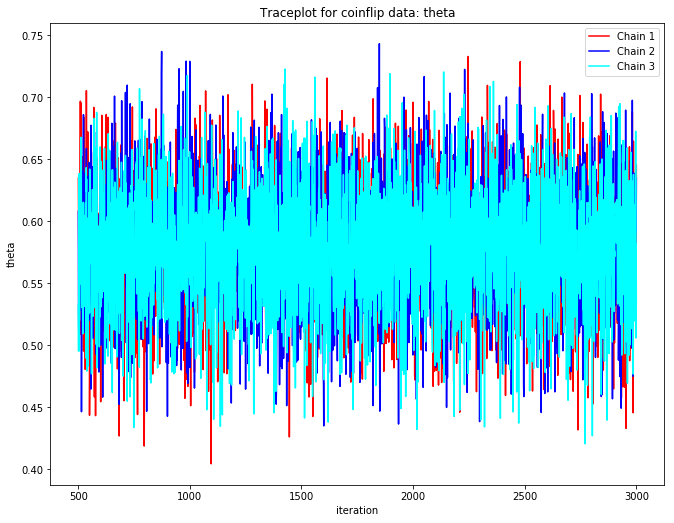

In [8]:
_ = plt.figure(figsize=(11,8.5))
_ = plt.plot(range(501,3001),coinflip_samples['theta'][0,:,0],color="red",label="Chain 1")
_ = plt.plot(range(501,3001),coinflip_samples['theta'][0,:,1],color="blue",label="Chain 2")
_ = plt.plot(range(501,3001),coinflip_samples['theta'][0,:,2],color="cyan",label="Chain 3")
_ = plt.xlabel("iteration")
_ = plt.ylabel("theta")
_ = plt.title("Traceplot for coinflip data: theta")
_ = plt.legend()

In [ ]:
#chain 1
coinflip_chain1 = coinflip_samples['theta'][0][:,0]
coinflip_chain1_df = pd.DataFrame({'theta':coinflip_chain1})
coinflip_chain1_mcmc = r_coda.mcmc(pandas2ri.py2ri(coinflip_chain1_df))

#chain 2
coinflip_chain2 = coinflip_samples['theta'][0][:,1]
coinflip_chain2_df = pd.DataFrame({'theta':coinflip_chain2})
coinflip_chain2_mcmc = r_coda.mcmc(pandas2ri.py2ri(coinflip_chain2_df))

#chain 3
coinflip_chain3 = coinflip_samples['theta'][0][:,2]
coinflip_chain3_df = pd.DataFrame({'theta':coinflip_chain3})
coinflip_chain3_mcmc = r_coda.mcmc(pandas2ri.py2ri(coinflip_chain3_df))

#convert to mcmc_list object
coinflip_chains=r_coda.mcmc_list(coinflip_chain1_mcmc,coinflip_chain2_mcmc,coinflip_chain3_mcmc)

#get n_eff and Rhat
coinflip_n_eff = np.round(np.array(r_coda.effectiveSize(coinflip_chains))) #round because must be an integer
coinflip_rhat = np.array(r_coda.gelman_diag(coinflip_chains).rx2("psrf"))
coinflip_rhat = coinflip_rhat[0][0] #extract point estimates

#calculate summary
coinflip_theta_summary = [np.mean(coinflip_samples['theta']),np.std(coinflip_samples['theta'])]
for i in [0.025,0.25,0.5,0.75,0.975]:
    coinflip_theta_summary.append(np.quantile(coinflip_samples['theta'],i))
coinflip_theta_summary.append(coinflip_n_eff[0])
coinflip_theta_summary.append(coinflip_rhat)
coinflip_summary = pd.DataFrame([coinflip_theta_summary],columns=["mean","sd","2.5%","25%","50%","75%","97.5%","n_eff","Rhat"],index=["theta"])
coinflip_summary.round(3)

### Exercise:

Try running the analysis above with different values of $p$ (the probability of the coin), as well as with different values for N (number of coin flips in the data). What do you observe?

In [ ]:
#try it here

## Example 2: Mean and Standard Deviation of the Normal

**Given samples from a normal distribution, we want to estimate its mean and standard deviation.**

In [ ]:
normal_code = '''
model {
    for (i in 1:N){
    x[i] ~ dnorm(mu, tau)
    }
mu ~ dnorm(0,.0001)
tau = pow(sigma, -2)
sigma ~ dunif(0,100)
}
'''

In [ ]:
#generate some data for our normal distribution
normal_N = 1000
true_mu = -5
true_sigma = 5
normal_x = np.random.normal(true_mu, true_sigma, 1000) #true data: mean = -5, standard deviation = 5

#prior is that this is a standard normal
init_mu = 0 
init_sigma = 1 

In [ ]:

normal_model = pyjags.Model(normal_code, data=dict(x=normal_x, N=normal_N), init = dict(mu=init_mu, sigma=init_sigma),chains=3)
normal_burnin = normal_model.sample(500, vars=['mu','sigma']) #warmup/burn-in
normal_samples = normal_model.sample(2500, vars=['mu','sigma'])


In [ ]:
_ = plt.figure(figsize=(11,8.5))
_ = plt.plot(range(500),normal_burnin['mu'][0,:,0],color="red",label="Chain 1")
_ = plt.plot(range(500),normal_burnin['mu'][0,:,1],color="blue",label="Chain 2")
_ = plt.plot(range(500),normal_burnin['mu'][0,:,2],color="cyan",label="Chain 3")
_ = plt.xlabel("iteration")
_ = plt.ylabel("mu")
_ = plt.title("Traceplot for normal data: mu")
_ = plt.legend()

In [ ]:
_ = plt.figure(figsize=(11,8.5))
_ = plt.plot(range(501,3001),normal_samples['mu'][0,:,0],color="red",label="Chain 1")
_ = plt.plot(range(501,3001),normal_samples['mu'][0,:,1],color="blue",label="Chain 2")
_ = plt.plot(range(501,3001),normal_samples['mu'][0,:,2],color="cyan",label="Chain 3")
_ = plt.xlabel("iteration")
_ = plt.ylabel("mu")
_ = plt.title("Traceplot for normal data: mu")
_ = plt.legend()

In [ ]:
_ = plt.figure(figsize=(11,8.5))
_ = plt.plot(range(500),normal_burnin['sigma'][0,:,0],color="red",label="Chain 1")
_ = plt.plot(range(500),normal_burnin['sigma'][0,:,1],color="blue",label="Chain 2")
_ = plt.plot(range(500),normal_burnin['sigma'][0,:,2],color="cyan",label="Chain 3")
_ = plt.xlabel("iteration")
_ = plt.ylabel("sigma")
_ = plt.title("Traceplot for normal data: sigma")
_ = plt.legend()

In [ ]:
_ = plt.figure(figsize=(11,8.5))
_ = plt.plot(range(501,3001),normal_samples['sigma'][0,:,0],color="red",label="Chain 1")
_ = plt.plot(range(501,3001),normal_samples['sigma'][0,:,1],color="blue",label="Chain 2")
_ = plt.plot(range(501,3001),normal_samples['sigma'][0,:,2],color="cyan",label="Chain 3")
_ = plt.xlabel("iteration")
_ = plt.ylabel("sigma")
_ = plt.title("Traceplot for normal data: sigma")
_ = plt.legend()

In [ ]:
#chain 1
normal_chain1 = np.column_stack((normal_samples['mu'][0][:,0],normal_samples['sigma'][0][:,0]))
normal_chain1_df = pd.DataFrame({'mu':normal_chain1[:,0],'sigma':normal_chain1[:,1]})
normal_chain1_mcmc = r_coda.mcmc(pandas2ri.py2ri(normal_chain1_df))
#chain 2
normal_chain2 = np.column_stack((normal_samples['mu'][0][:,1],normal_samples['sigma'][0][:,1]))
normal_chain2_df = pd.DataFrame({'mu':normal_chain2[:,0],'sigma':normal_chain2[:,1]})
normal_chain2_mcmc = r_coda.mcmc(pandas2ri.py2ri(normal_chain2_df))
#chain 3
normal_chain3 = np.column_stack((normal_samples['mu'][0][:,2],normal_samples['sigma'][0][:,2]))
normal_chain3_df = pd.DataFrame({'mu':normal_chain3[:,0],'sigma':normal_chain3[:,1]})
normal_chain3_mcmc = r_coda.mcmc(pandas2ri.py2ri(normal_chain3_df))
#convert to mcmc_list object
normal_chains=r_coda.mcmc_list(normal_chain1_mcmc,normal_chain2_mcmc,normal_chain3_mcmc)
#get n_eff and Rhat
normal_n_eff = np.round(np.array(r_coda.effectiveSize(normal_chains))) #round because must be an integer
normal_rhat = np.array(r_coda.gelman_diag(normal_chains).rx2("psrf"))
normal_rhat = np.array([normal_rhat[0][0],normal_rhat[1][0]]) #extract point estimates
#calculate summary
normal_mu_summary = [np.mean(normal_samples['mu']),np.std(normal_samples['mu'])]
normal_sigma_summary = [np.mean(normal_samples['sigma']),np.std(normal_samples['sigma'])]
for i in [0.025,0.25,0.5,0.75,0.975]:
    normal_mu_summary.append(np.quantile(normal_samples['mu'],i))
    normal_sigma_summary.append(np.quantile(normal_samples['sigma'],i))
normal_mu_summary.append(normal_n_eff[0])
normal_mu_summary.append(normal_rhat[0])
normal_sigma_summary.append(normal_n_eff[1])
normal_sigma_summary.append(normal_rhat[1])
normal_summary = pd.DataFrame([normal_mu_summary,normal_sigma_summary],columns=["mean","sd","2.5%","25%","50%","75%","97.5%","n_eff","Rhat"],index=["mu","sigma"])
normal_summary.round(3)

### Exercise:

Try varying the length of the burn-in period and number of iterations in the chains. What do you observe?

In [ ]:
#try it here

## Example 3: Linear Regression

**We will run a simple linear regression using JAGS.**

In [ ]:
regression_code = '''
model {       
    for (i in 1:N){
        y[i] ~ dnorm(mu[i], tau)
        mu[i] = a + b * x[i]       
    }       
a ~ dnorm(0, .0001)       
b ~ dnorm(0, .0001)       
tau = pow(sigma, -2)       
sigma ~ dunif(0, 100)
}
'''

In [ ]:
regression_N = 1000
true_b = 5
true_a = 70
regression_x = np.arange(1,1001)
regression_epsilon = np.random.normal(true_a,100,1000)
regression_y = true_b*regression_x + regression_epsilon
#prior is that y = x (i.e., a = 0, b = 1)
prior_a = 0
prior_b = 1

In [ ]:
regression_model = pyjags.Model(regression_code, data=dict(x=regression_x, y=regression_y, N = regression_N), init = dict(a = prior_a, b = prior_b),chains=3)
regression_burnin = regression_model.sample(500, vars=['a','b']) #warmup/burn-in
regression_samples = regression_model.sample(2500, vars=['a','b'])

In [ ]:
_ = plt.figure(figsize=(11,8.5))
_ = plt.plot(range(500),regression_burnin['a'][0,:,0],color="red",label="Chain 1")
_ = plt.plot(range(500),regression_burnin['a'][0,:,1],color="blue",label="Chain 2")
_ = plt.plot(range(500),regression_burnin['a'][0,:,2],color="cyan",label="Chain 3")
_ = plt.xlabel("iteration")
_ = plt.ylabel("a")
_ = plt.title("Traceplot for regression data: a")
_ = plt.legend()

In [ ]:
_ = plt.figure(figsize=(11,8.5))
_ = plt.plot(range(501,3001),regression_samples['a'][0,:,0],color="red",label="Chain 1")
_ = plt.plot(range(501,3001),regression_samples['a'][0,:,1],color="blue",label="Chain 2")
_ = plt.plot(range(501,3001),regression_samples['a'][0,:,2],color="cyan",label="Chain 3")
_ = plt.xlabel("iteration")
_ = plt.ylabel("a")
_ = plt.title("Traceplot for regression data: a")
_ = plt.legend()

In [ ]:
_ = plt.figure(figsize=(11,8.5))
_ = plt.plot(range(500),regression_burnin['b'][0,:,0],color="red",label="Chain 1")
_ = plt.plot(range(500),regression_burnin['b'][0,:,1],color="blue",label="Chain 2")
_ = plt.plot(range(500),regression_burnin['b'][0,:,2],color="cyan",label="Chain 3")
_ = plt.xlabel("iteration")
_ = plt.ylabel("b")
_ = plt.title("Traceplot for regression data: b")
_ = plt.legend()

In [ ]:
_ = plt.figure(figsize=(11,8.5))
_ = plt.plot(range(501,3001),regression_samples['b'][0,:,0],color="red",label="Chain 1")
_ = plt.plot(range(501,3001),regression_samples['b'][0,:,1],color="blue",label="Chain 2")
_ = plt.plot(range(501,3001),regression_samples['b'][0,:,2],color="cyan",label="Chain 3")
_ = plt.xlabel("iteration")
_ = plt.ylabel("b")
_ = plt.title("Traceplot for regression data: b")
_ = plt.legend()

In [ ]:
#chain 1
regression_chain1 = np.column_stack((regression_samples['a'][0][:,0],regression_samples['b'][0][:,0]))
regression_chain1_df = pd.DataFrame({'a':regression_chain1[:,0],'b':regression_chain1[:,1]})
regression_chain1_mcmc = r_coda.mcmc(pandas2ri.py2ri(regression_chain1_df))

#chain 2
regression_chain2 = np.column_stack((regression_samples['a'][0][:,1],regression_samples['b'][0][:,1]))
regression_chain2_df = pd.DataFrame({'a':regression_chain2[:,0],'b':regression_chain2[:,1]})
regression_chain2_mcmc = r_coda.mcmc(pandas2ri.py2ri(regression_chain2_df))

#chain 3
regression_chain3 = np.column_stack((regression_samples['a'][0][:,2],regression_samples['b'][0][:,2]))
regression_chain3_df = pd.DataFrame({'a':regression_chain3[:,0],'b':regression_chain3[:,1]})
regression_chain3_mcmc = r_coda.mcmc(pandas2ri.py2ri(regression_chain3_df))

#convert to mcmc_list object
regression_chains=r_coda.mcmc_list(regression_chain1_mcmc,regression_chain2_mcmc,regression_chain3_mcmc)

#get n_eff and Rhat
regression_n_eff = np.round(np.array(r_coda.effectiveSize(regression_chains))) #round because must be an integer
regression_rhat = np.array(r_coda.gelman_diag(regression_chains).rx2("psrf"))
regression_rhat = np.array([regression_rhat[0][0],regression_rhat[1][0]]) #extract point estimates

#calculate summary
regression_a_summary = [np.mean(regression_samples['a']),np.std(regression_samples['a'])]
regression_b_summary = [np.mean(regression_samples['b']),np.std(regression_samples['b'])]
for i in [0.025,0.25,0.5,0.75,0.975]:
    regression_a_summary.append(np.quantile(regression_samples['a'],i))
    regression_b_summary.append(np.quantile(regression_samples['b'],i))
regression_a_summary.append(regression_n_eff[0])
regression_a_summary.append(regression_rhat[0])
regression_b_summary.append(regression_n_eff[1])
regression_b_summary.append(regression_rhat[1])
regression_summary = pd.DataFrame([regression_a_summary,regression_b_summary],columns=["mean","sd","2.5%","25%","50%","75%","97.5%","n_eff","Rhat"],index=["a","b"])
regression_summary.round(3)

### Exercise:

Compare the results of performing a linear regression with this method and a non-Bayesian approach (say, using the sklearn LinearRegression function). What do you observe?

In [ ]:
#try it here


## Example 4: Reinforcement Learning with Open AI Gym

In this lab we are going to work with OpenAIgym's FrozenLake environment. The details of the environment can be found in the link https://gym.openai.com/envs/FrozenLake-v0/. 


Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. 

The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.

The surface is described using a grid like the following:
[PP: WOULD IT BETTER TO INCLUDE A DIAGRAM]

- S: starting point, safe
- F: frozen surface, safe
- H: hole, fall to your doom
- G: goal, where the frisbee is located

SFFF  <br> 
FHFH <br> 
FFFH  <br> 
HFFG <br> 

Expected actions are Left(0), Right(1), Down(2), Up(3). 

The episode ends when you reach the goal or fall in a hole. You receive a reward of 1 if you reach the goal, and zero otherwise.


In [ ]:
import gym
from gym.envs.registration import register
register(id='FrozenLakeNotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '4x4', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=0.8196, # optimum = .8196
)

In [ ]:
from gym.envs.registration import register
register(
    id='FrozenLake8x8NotSlippery-v0',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name' : '8x8', 'is_slippery': False},
    max_episode_steps=100,
    reward_threshold=0.8196, # optimum = .8196
)

*hint:* If you receive an error message while registering the above env the second time you run this cell again, ignore the error message or restart the kernel. 

Throughout the assignment, use only the environments we registered in the previous cells:
- `FrozenLake8x8NotSlippery-v0`
- `FrozenLakeNotSlippery-v0` 

Even though the original problem description has slippery environment, we are working in a non-slippery environment. In our environment, if you go right, you only go right whereas in the original environment, if you intend to go right, you can go right, up or down with 1/3 probability.



In [ ]:
import gym
import numpy as np

#Change environment to FrozenLake8x8 to see grid.
env = gym.make('FrozenLake-v0')
# env = gym.make('FrozenLake8x8NotSlippery-v0')

print(env.observation_space.n)


#Both the grids look like as follows.
'''
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ]'''

#env.render() prints the frozenlake with an indicator showing where the agent is. You can use it for debugging.
env.render()

In [ ]:
print(env.observation_space.n)
print(env.action_space.n)

In [ ]:
Q = np.zeros([env.observation_space.n,env.action_space.n])

def choose_action(state):
    return np.random.choice(np.array([0,1,2,3]))

def learn(s, s1, r, a):
    return

In [ ]:
# Set learning parameters
################

# num_episodes = 2000
# epsilon = 0.0
# max_steps = 100
# lr_rate = 0.0
# gamma = 0.0
# rList = []

num_episodes = 10
max_iter_per_episode = 20
for i in range(num_episodes):
    iter = 0
            
    #Reset environment and get an initial state - should be done at start of each episode.
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    while iter < max_iter_per_episode:
        iter+=1
        #Choose an action
        a = choose_action(s)
        # env.step() gives you next state, reward, done(whether the episode is over)
        # s1 - new state, r-reward, d-whether you are done or not
        s1,r,d,_ = env.step(a)
        print('State : ',s, ' Action : ', a, ' State 1 : ', s1, ' Reward : ',r, 'Done : ', d)
        
        learn(s, s1, r, a)
        
        if d:
            print('Episode Over')
            if r != 1:
                print('Fell into hole with reward ', r)            
            break
        s = s1
    if r==1:
        print(i)
        break